# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

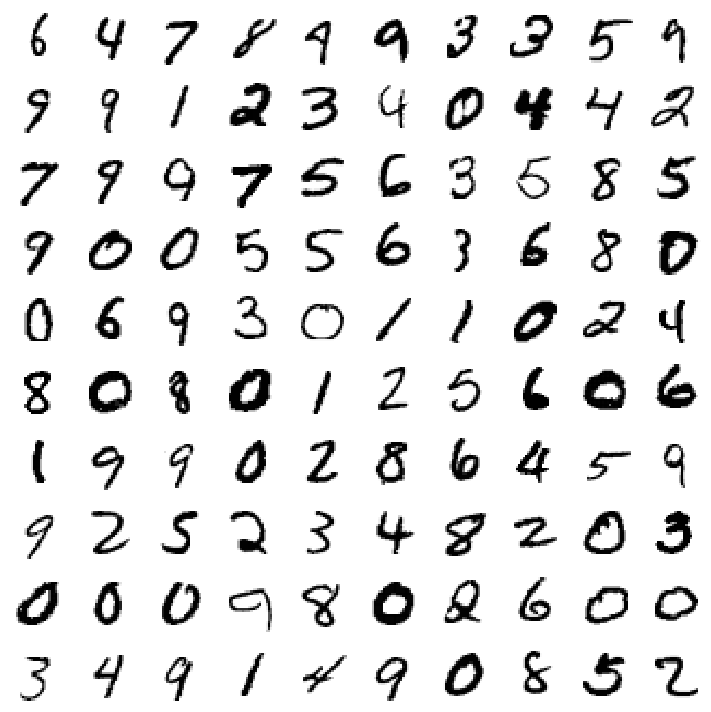

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

Compile and train the network (note that this could take a while).

In [4]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12


ValueError: in user code:

    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\merel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 10) and (None, 1, 1, 64) are incompatible


Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03277942165732384
Test accuracy: 0.9909999966621399


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


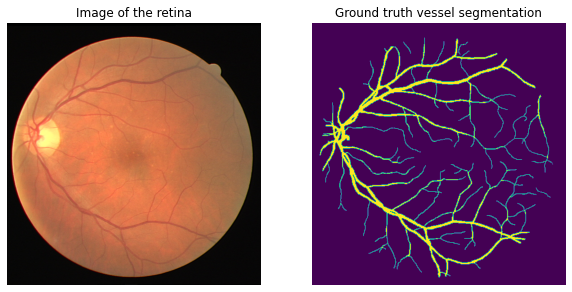

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import sys
sys.path.append('code/')
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = r"data/datasets/"
train_paths = glob(data_folder + r"training\images\*.tif")
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


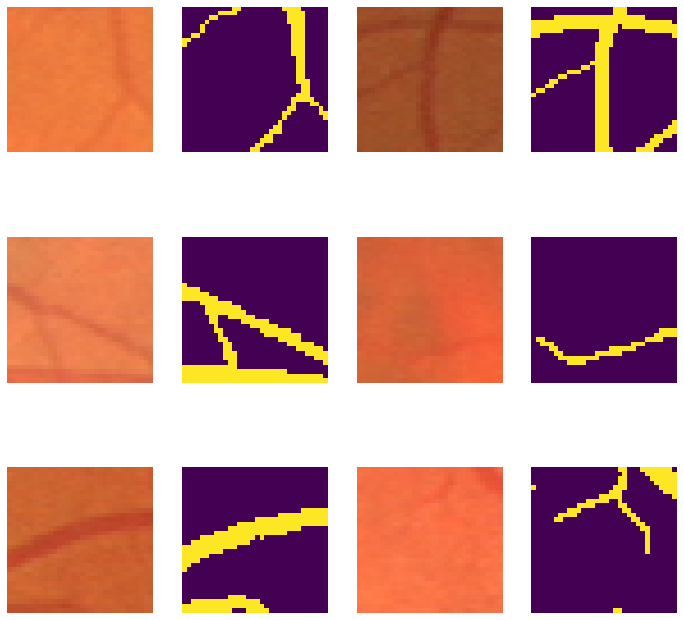

In [7]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [8]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [9]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 2
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)


C:\Users\s160518\AppData\Local\Continuum\anaconda3\envs\my-python-3.9\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
50/50 - 92s - loss: 0.5377 - accuracy: 0.7929 - val_loss: 0.5009 - val_accuracy: 0.9211
Epoch 2/2
50/50 - 60s - loss: 0.3340 - accuracy: 0.9441 - val_loss: 0.3630 - val_accuracy: 0.9068


### Visualizing the segmentation results

In [37]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test\images\*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/datasets/test\\1st_manual\\01_manual1.gif'

# Exercises
## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

$\textbf{Answers:}$These parameters correspond to the number trainable parameters in the modellayer. The general expressions for these two different layers are: <br>

$\textbf{1: convolutional layer}$ number of parameters = filters x kernel size x input layer size + biases( number of filters)
in the MNIST example the parameters for the convolutional layer is given by: $32 * (3 * 3) * 1 + 32 = 320$ parameters <br>

$\textbf{2: fully-connected layer}$ number of parameters = output size * (input layer size + 1)
in the MNIST example the fully connected layer is calculated by: 
$128 * (9216 + 1) = 1179776 $ parameters

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Conv2D(64, (10,10), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(64, (1,1), activation='relu'))


#model.add(Dense(10, activation='softmax'))


#output moet 1,1,10 zijn..
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 64)          8


## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>


$\textbf{Answers:}$ <br>
Skip connections in the U-net add the outputs from the encoding path to the decoding path. The skip connections are able to recover the fine-grained details in the predictions. <br>
*It is possible to train same architecture without skip connections! (I did tried this), no errors.* <br>
*Expected result would be less detailed (???).*


In [49]:
import os
from unet_model import unet
from unet_model_no_skip_connections import unet_no_skip_connections
from unet_utils import datagenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from unet_utils import extract_patches, preprocessing

# Function that trains the u_net model with or without skip connections
def train_Unet_model(skip_connections, X_train_data = [],y_train_data = []):
 
    # work with 32x32 patches
    patch_size = (32, 32)

    # 200 patches per image
    patches_per_im = 200

    # visualize a couple of patches as a visual check
    patches, patches_segmentations = extract_patches(X_train_data, y_train_data, patch_size, patches_per_im=1, seed=7)

    # hyperparameters
    depth = 3
    channels = 32
    use_batchnorm = True
    batch_size = 64
    epochs = 2
    patches_per_im = 200
    steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

   
    # 200 patches per image
    
    
    # initialize model
    if skip_connections == 1:
        unet_model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)
    if skip_connections == 0:
        unet_model = unet_no_skip_connections(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

    # print a summary of the model
    # model.summary(line_length=120)

    # compile the model
    unet_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # stop the training if the validation loss does not increase for 15 consecutive epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # train the model with the data generator, and save the training history
    hist = unet_model.fit_generator(datagenerator(X_train_data, y_train_data, patch_size, patches_per_im, batch_size),
                                  validation_data=(val_images, val_segmentations),
                                  steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                                  callbacks=[early_stopping])
    return unet_model, hist

# Function that saves the model (json and h5) and the training and validation losses
def save_models(name, model, history):
    # Save model
    model_json = model1.to_json()
    with open(fr"{name}_model.json", "w") as json_file:
        json_file.write(model_json)
    # save weights
    model1.save(fr'{name}_model.h5') 
    # save losses
    train_loss = hist.history['loss']
    np.save(fr'{name}_train_loss', train_loss)
    val_loss = hist.history['val_loss']
    np.save(fr'{name}_validation_loss', val_loss)



C:\Users\s160518\AppData\Local\Continuum\anaconda3\envs\my-python-3.9\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
50/50 - 83s - loss: 0.5356 - accuracy: 0.8005 - val_loss: 0.5011 - val_accuracy: 0.9211
Epoch 2/2
50/50 - 76s - loss: 0.3209 - accuracy: 0.9382 - val_loss: 0.3456 - val_accuracy: 0.9211


C:\Users\s160518\AppData\Local\Continuum\anaconda3\envs\my-python-3.9\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
50/50 - 72s - loss: 0.6185 - accuracy: 0.7162 - val_loss: 0.4990 - val_accuracy: 0.9211
Epoch 2/2
50/50 - 68s - loss: 0.4203 - accuracy: 0.9110 - val_loss: 0.3171 - val_accuracy: 0.9211


In [ ]:
# define training set
X_train, y_train = np.expand_dims(train_images, axis=0), np.expand_dims(train_segmentations, axis=0)
    
# Train u_net model (with skip connections)
Unet_model, hist = train_Unet_model(1, train_images, train_segmentations)
save_models('unet', Unet_model, hist) # save

# Train model without skip connections
Unet_model_no_skip_connections, hist1  = train_Unet_model(0, train_images, train_segmentations)
save_models('unet_no_skip_connections', Unet_model_no_skip_connections, hist1) # save


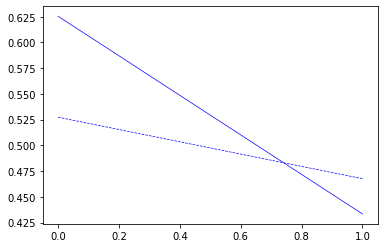

In [40]:
from tensorflow.keras.models import load_model
modeltest = load_model('u_net_no_skip_connections_model.h5')
#modeltest.summary()

training_loss = np.load(r"u_net_no_skip_connections_train_loss.npy")
validation_loss= np.load(r"u_net_no_skip_connections_validation_loss.npy")

fig,ax=plt.subplots(1,1)
ax.plot(training_loss,'b',linewidth=0.7,label='Training 1')
ax.plot(validation_loss,'b--',linewidth=0.7,label='Validation 1')

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

$\textbf{Answers:}$
Data augmentation is a way to increase the size of a dataset without showing identical samples. 
It will learn more general features about the classes, therefore the model becomes more robust to small changes in the input data.
This implies that the overfitting will be less. 

Test samples are considered to be unseen real-world data and it is common practice to 'not touch' the test data. 
Therefore it is uncommon to apply data augmentation to test data. 

However, data augmentation can be applied to test samples to improve the prediction of the model. 
This is especially helpfull when the model is not confident that the sample belongs to one specific class. 
By only presenting the original sample to the model, it might predict the class wrong. 
However by presenting the test sample multiple times to the model, but each time as an augmented version of the original sample,
the model makes different errors in the prediction. By averaging the predictions of the augmented samples, the error of the prediction is also averaged. 
This results in a better estimated prediction of the original test sample.

Sidenote to the types of data augmentation is that these should not change the class of the sample.


To train the model, all the training images have been used. Two functions are created to augmentate the original training images either by random brightness augmentation or by b-spline geometric augmentation. These images are than combined to create the entire training dataset. The validation and test images have been kept the same.

The models are then training, the test data is predicted and the models are compared by the use of an ROC curve.

In [89]:
# script for brightness augmentation

#only brightness
import random
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc


def brightness_augmentation(train_images = [], brightness_range = [0.5,1.5]):
    augmented_data = []
    imageNew = expand_dims(train_images[0], 0)
    imageDataGen = ImageDataGenerator(brightness_range=brightness_range)
    iterator = imageDataGen.flow(imageNew, batch_size=1)

    for k in range(len(train_images)):
        batch = iterator.next()
        image = np.array(batch[0].astype('uint8'))
        augmented_data.append(image/255)
    return np.array(augmented_data)


def plot_roc_curve(y_pred=[], y_true=[],title = ''):
    fpr,tpr,treshold = roc_curve(np.round(y_pred.reshape(np.size(y_pred))), y_true.reshape(np.size(y_true)))
    print(fpr,tpr)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr,tpr,color = 'darkorange',label = 'AUC = %0.2f' %roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.show()
    
train_images_bright = np.concatenate((train_images,brightness_augmentation(train_images = train_images)),axis=0)
train_segmentations_bright = np.concatenate((train_segmentations,train_segmentations),axis=0)

In [ ]:
model_bright,hist_bright = train_Unet_model(skip_connections=1,X_train_data = train_images_bright,y_train_data = train_segmentations_bright)
save_models('bright_augmentation', model_bright, hist_bright) # save

In [ ]:
test_prediction_bright = model_bright.predict(test_images, batch_size=4)

In [ ]:
plot_roc_curve(y_pred = test_prediction_bright,y_true =test_segmentations,title= 'Brightness data augmentation model')

In [ ]:
#brightness and b-spline geometric augmentation
import gryds
import copy 

def bspline_func(image_input=[],random_grid= []):
     # Define a B-spline transformation object
    bspline = gryds.BSplineTransformation(random_grid)

    # Define an interpolator object for the image:
    interpolator = gryds.Interpolator(image_input)

    # Transform the image using the B-spline transformation
    transformed_image = interpolator.transform(bspline)
    return transformed_image


def gryds_augmentation(input_images = [],input_segmentations = [],input_masks=[]):
    augmented_images = []
    augmented_segmentations = []
    augmented_masks = []

    for j in range(len(input_images)):
        bsplined_image = copy.deepcopy(input_images[1])

        # Define a random 3x3 B-spline grid for a 2D image:
        random_grid = np.random.rand(2, 3, 3)
        random_grid -= 0.5
        random_grid /= 5



        for i in range(3):
            transformed_image = bspline_func(bsplined_image[:,:,i],random_grid)
            bsplined_image[:,:,i] = transformed_image  
        bsplined_segmentation = bspline_func(input_segmentations[1,:,:,0],random_grid)
        bsplined_mask = bspline_func(input_masks[1,:,:,0],random_grid)

        
        augmented_images.append(bsplined_image)
        augmented_segmentations.append(bsplined_segmentation)
        augmented_masks.append(bsplined_mask)
    
    augmented_images = np.array(augmented_images)
    augmented_segmentations = np.array(augmented_segmentations)
    augmented_masks = np.array(augmented_masks)
    return augmented_images, new_segmentations[:,:,:,np.newaxis], new_masks[:,:,:,np.newaxis]

new_images,new_segmentations,new_masks = gryds_augmentation(train_images,train_segmentations,train_masks)

training_images_gryds = np.concatenate((train_images,brightness_augmentation(train_images = train_images),new_images),axis=0)
training_segmentations_gryds = np.concatenate((train_segmentations,train_segmentations,new_segmentations),axis=0)
training_masks_gryds = np.concatenate((train_masks,train_masks,new_masks),axis=0)


In [ ]:
model_bright_gryds,hist_bright_gryds = train_Unet_model(skip_connections=1,X_train_data = training_images_gryds,y_train_data = training_segmentations_gryds)
save_models('bright_gryds_augmentation', model_bright_gryds, hist_bright_gryds) # save

In [ ]:
test_prediction_bright_gryds = model_bright_gryds.predict(test_images, batch_size=4)

In [ ]:
plot_roc_curve(y_pred = test_prediction_bright_gryds,y_true =test_segmentations,title= 'Brightness and b-spline geometric data augmentation model')